# Case 2: How LDES reacts to different reserve requirements?

## Scheme 1 (c1s2b20 - No reserve requirements)

In [96]:
using CSV, DataFrames, JuMP, HiGHS, SCIP, Clp

storageinfo = CSV.read(joinpath("cleaned","storageinfo.csv"), DataFrame)
generatorinfo = CSV.read(joinpath("cleaned","generatorinfo.csv"), DataFrame)
vreinfo = CSV.read(joinpath("cleaned","vreinfo.csv"), DataFrame)
halfhourlydemand = CSV.read(joinpath("cleaned","halfhourlydemand.csv"), DataFrame)
halfhourlyvrecf = CSV.read(joinpath("cleaned","halfhourlyvrecf.csv"), DataFrame)
halfhourlydemand = halfhourlydemand[1:1440,:];

In [9]:
function case2scheme1(vreinfo, generatorinfo, storageinfo, halfhourlydemand, halfhourlyvrecf; 
    budget, voll, bigm, epsilon)

    # SETS
    V = vreinfo.id
    G = generatorinfo.id
    S = storageinfo.id
    T = halfhourlydemand.hh
    T1 = T[2:end]

    # INITIATE MODEL
    model = Model()
    set_optimizer(model, HiGHS.Optimizer)

    # DECISION VARIABLES
    @variables(model, begin
        CAPG[G] >= 0
        CAPS[S] >= 0
        SOCM[S] >= 0
        GEN[G,T] >= 0
        SOC[S,T] >= 0
        CHARGE[S,T] >= 0
        DISCHARGE[S,T] >= 0
        CURTAIL[V,T] >= 0
        NSE[T] >= 0
    end)

    # BUDGET CONSTRAINT
    @expression(model, GenInvCost, sum(generatorinfo[generatorinfo.id.==g,:fixedCost][1] * CAPG[g] for g in G))
    @expression(model, StorPowInvCost, sum(0.8e3 * storageinfo[storageinfo.id.==s,:bestCasePowerCost][1] * CAPS[s] for s in S))
    @expression(model, StorEnInvCost, sum(0.8e3 * storageinfo[storageinfo.id.==s,:bestCaseEnergyCost][1] * SOCM[s] for s in S))
    @expression(model, TIC, GenInvCost + StorPowInvCost + StorEnInvCost)
    @constraint(model, cBudget, TIC <= budget)

    # OBJECTIVE FUNCTION
    @expression(model, EnergyProvisionCost, 
        sum(0.5 * generatorinfo[generatorinfo.id.==g,:varCost][1] * GEN[g,t] for g in G for t in T))
    @expression(model, UnservedEnergyCost, 
        sum(0.5 * voll * NSE[t] for t in T))
    @expression(model, CurtailedVreCost,
        sum(0.5 * vreinfo[vreinfo.id.==v,:varCost][1] * CURTAIL[v,t] for v in V for t in T))
    @expression(model, PenaltyChargeDischarge, 5 * sum(CHARGE[g,t] + DISCHARGE[g,t] for g in G for t in T))
    @objective(model, Min, EnergyProvisionCost + UnservedEnergyCost + CurtailedVreCost + PenaltyChargeDischarge)

    # POWER BALANCE CONSTRAINT
    @constraint(model, c01[t in T], sum(GEN[g,t] for g in G) + NSE[t] - sum(CURTAIL[v,t] for v in V) +
        sum(vreinfo[vreinfo.id.==v,:installedMW][1] * 
        halfhourlyvrecf[(halfhourlyvrecf.hh.==t) .& (halfhourlyvrecf.vre_id.==v),:cf][1] for v in V) +
        sum(DISCHARGE[s,t] for s in S) - sum(CHARGE[s,t] for s in S) == 
        halfhourlydemand[halfhourlydemand.hh.==t,:load][1])
    
    # GENERATOR LIMIT CONSTRAINT
    @constraint(model, c90[g in G, t in T], GEN[g,t] <= CAPG[g])

    # GENERATOR RAMP UP CONSTRAINT
    @constraint(model, c11[g in G, t in T1], 
        GEN[g,t] - GEN[g,t-1] <= generatorinfo[generatorinfo.id.==g,:rampupRate][1] * CAPG[g])
    
    # GENERATOR RAMP DOWN CONSTRAINT
    @constraint(model, c12[g in G, t in T1],
        GEN[g,t-1] - GEN[g,t] <= generatorinfo[generatorinfo.id.==g,:rampdownRate][1] * CAPG[g])
    
    # VRE CURTAIL CONSTRAINT
    @constraint(model, c13[v in V, t in T], CURTAIL[v,t] <= 
        vreinfo[vreinfo.id.==v,:installedMW][1] * 
        halfhourlyvrecf[(halfhourlyvrecf.hh.==t) .& (halfhourlyvrecf.vre_id.==v),:cf][1])
    
    # STORAGE CHARGE LIMIT CONSTRAINT
    @constraint(model, c92[s in S, t in T], CHARGE[s,t] <= CAPS[s])

    # STORAGE DISCHARGE LIMIT CONSTRAINT
    @constraint(model, c93[s in S, t in T], DISCHARGE[s,t] <= CAPS[s])
    
    # STORAGE SOC LIMIT CONSTRAINT
    @constraint(model, c19[s in S, t in T], SOC[s,t] <= SOCM[s])
    @constraint(model, c20[s in S], SOC[s,minimum(T)] == 0.5 * SOCM[s])
    @constraint(model, c21[s in S], SOC[s,maximum(T)] == 0.5 * SOCM[s])

    # STORAGE SOC UPDATE CONSTRAINT
    @constraint(model, c22[s in S, t in T1], SOC[s,t] == SOC[s,t-1] + 
        (CHARGE[s,t] * storageinfo[storageinfo.id.==s,:bestCaseEff][1]) - 
        (DISCHARGE[s,t] / storageinfo[storageinfo.id.==s,:bestCaseEff][1]))

    optimize!(model)

    return(
        CAPG = value.(CAPG).data,
        CAPS = value.(CAPS).data,
        SOCM = value.(SOCM).data,
        GEN = value.(GEN).data,
        SOC = value.(SOC).data,
        CHARGE = value.(CHARGE).data,
        DISCHARGE = value.(DISCHARGE).data,
        NET_DISCHARGE = value.(DISCHARGE).data .- value.(CHARGE).data,
        CURTAIL = value.(CURTAIL).data,
        NSE = value.(NSE).data,
        GenInvCost = value(GenInvCost),
        StorPowInvCost = value(StorPowInvCost),
        StorEnInvCost = value(StorEnInvCost),
        TIC = value(TIC),
        EnergyProvisionCost = value(EnergyProvisionCost),
        UnservedEnergyCost = value(UnservedEnergyCost),
        CurtailedVreCost = value(CurtailedVreCost),
        OV = objective_value(model),
    )
end

case2scheme1 (generic function with 1 method)

In [10]:
c2s1 = case2scheme1(vreinfo, generatorinfo, storageinfo, halfhourlydemand, halfhourlyvrecf; 
budget=20e9, voll=1e6, bigm=100e3, epsilon=0.05)

Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
90675 rows, 68156 cols, 272540 nonzeros
90675 rows, 68156 cols, 272540 nonzeros
Presolve : Reductions: rows 90675(-4376); columns 68156(-994); elements 272540(-5398)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 1440(3.86983e+08) 0s
       4528     2.1458886839e+04 Pr: 15257(1.02466e+11); Du: 0(7.52599e-07) 5s
       7635     5.6413823875e+04 Pr: 19965(2.23581e+11); Du: 0(7.57454e-07) 10s
      10423     1.2837687197e+05 Pr: 24642(5.86484e+11); Du: 0(5.36343e-07) 15s
      12715     1.8091749934e+05 Pr: 24662(1.20779e+12); Du: 0(6.46191e-07) 20s
      15028     2.2304843530e+05 Pr: 28469(1.56283e+12); Du: 0(7.36232e-07) 26s
      16994     2.5589785954e+05 Pr: 37233(4.45319e+11); Du: 0(9.0154e-07) 31s
      19298     2.8482198280e+05 Pr: 31808(3.20125e+12); Du: 0(1.13274e-06) 36s
      213

(CAPG = [4357.88057476665, 24147.563702701395], CAPS = [-0.0, 12915.264351236765, -0.0, -0.0, 2738.291371295227, 0.0, 0.0, 0.0, -0.0, -0.0, 5660.399999999995, -0.0, -0.0, -0.0], SOCM = [-0.0, 2.268530961275762e6, -0.0, -0.0, 199584.2600355829, -0.0, -0.0, -0.0, -0.0, -0.0, 66998.18181818399, 0.0, -0.0, -0.0], GEN = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], SOC = [-0.0 -0.0 … 0.0 -0.0; 1.134265480637881e6 1.1429187077532096e6 … 1.1335166886378808e6 1.134265480637881e6; … ; -0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … -0.0 -0.0], CHARGE = [0.0 0.0 … -0.0 -0.0; 0.0 12915.264351236765 … 202.59999999978035 1117.6000000001973; … ; -0.0 -0.0 … 0.0 0.0; -0.0 -0.0 … 0.0 0.0], DISCHARGE = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 -0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], NET_DISCHARGE = [0.0 0.0 … 0.0 0.0; 0.0 -12915.264351236765 … -202.59999999978035 -1117.6000000001973; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], CURTAIL = [-0.0 -0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 9314.10862870478 1414.2442774680112 … 0.0 0.

## Scheme 2 Fixed reserve requirements (1800MW)

In [11]:
function case2scheme2(vreinfo, generatorinfo, storageinfo, halfhourlydemand, halfhourlyvrecf; 
    budget, voll, bigm, epsilon)

    # SETS
    V = vreinfo.id
    G = generatorinfo.id
    S = storageinfo.id
    T = halfhourlydemand.hh
    T1 = T[2:end]

    # INITIATE MODEL
    model = Model()
    set_optimizer(model, HiGHS.Optimizer)

    # DECISION VARIABLES
    @variables(model, begin
        CAPG[G] >= 0
        CAPS[S] >= 0
        SOCM[S] >= 0
        GEN[G,T] >= 0
        R_GEN[G,T] >= 0
        SOC[S,T] >= 0
        CHARGE[S,T] >= 0
        DISCHARGE[S,T] >= 0
        R_DISCHARGE[S,T] >= 0
        CURTAIL[V,T] >= 0
        NSE[T] >= 0
    end)

    # BUDGET CONSTRAINT
    @expression(model, GenInvCost, sum(generatorinfo[generatorinfo.id.==g,:fixedCost][1] * CAPG[g] for g in G))
    @expression(model, StorPowInvCost, sum(0.8e3 * storageinfo[storageinfo.id.==s,:bestCasePowerCost][1] * CAPS[s] for s in S))
    @expression(model, StorEnInvCost, sum(0.8e3 * storageinfo[storageinfo.id.==s,:bestCaseEnergyCost][1] * SOCM[s] for s in S))
    @expression(model, TIC, GenInvCost + StorPowInvCost + StorEnInvCost)
    @constraint(model, cBudget, TIC <= budget)

    # OBJECTIVE FUNCTION
    @expression(model, EnergyProvisionCost, 
        sum(0.5 * generatorinfo[generatorinfo.id.==g,:varCost][1] * GEN[g,t] for g in G for t in T))
    @expression(model, ReserveProvisionCost,
        sum(0.5 * generatorinfo[generatorinfo.id.==g,:varCost][1] * R_GEN[g,t] for g in G for t in T) + sum(5 * R_DISCHARGE[s,t] for s in S for t in T))
    @expression(model, UnservedEnergyCost, 
        sum(0.5 * voll * NSE[t] for t in T))
    @expression(model, CurtailedVreCost,
        sum(0.5 * vreinfo[vreinfo.id.==v,:varCost][1] * CURTAIL[v,t] for v in V for t in T))
    @expression(model, PenaltyChargeDischarge, 5 * sum(CHARGE[g,t] + DISCHARGE[g,t] for g in G for t in T))
    @objective(model, Min, EnergyProvisionCost + ReserveProvisionCost + UnservedEnergyCost + CurtailedVreCost + PenaltyChargeDischarge)

    # POWER BALANCE CONSTRAINT
    @constraint(model, c01[t in T], sum(GEN[g,t] for g in G) + NSE[t] - sum(CURTAIL[v,t] for v in V) +
        sum(vreinfo[vreinfo.id.==v,:installedMW][1] * 
        halfhourlyvrecf[(halfhourlyvrecf.hh.==t) .& (halfhourlyvrecf.vre_id.==v),:cf][1] for v in V) +
        sum(DISCHARGE[s,t] for s in S) - sum(CHARGE[s,t] for s in S) == 
        halfhourlydemand[halfhourlydemand.hh.==t,:load][1])
    
    # GENERATOR LIMIT CONSTRAINT
    @constraint(model, c90[g in G, t in T], GEN[g,t] + R_GEN[g,t] <= CAPG[g])

    # GENERATOR RAMP UP CONSTRAINT
    @constraint(model, c11[g in G, t in T1], 
        GEN[g,t] - GEN[g,t-1] <= generatorinfo[generatorinfo.id.==g,:rampupRate][1] * CAPG[g])
    
    # GENERATOR RAMP DOWN CONSTRAINT
    @constraint(model, c12[g in G, t in T1],
        GEN[g,t-1] - GEN[g,t] <= generatorinfo[generatorinfo.id.==g,:rampdownRate][1] * CAPG[g])
    
    # VRE CURTAIL CONSTRAINT
    @constraint(model, c13[v in V, t in T], CURTAIL[v,t] <= 
        vreinfo[vreinfo.id.==v,:installedMW][1] * 
        halfhourlyvrecf[(halfhourlyvrecf.hh.==t) .& (halfhourlyvrecf.vre_id.==v),:cf][1])
    
    # STORAGE CHARGE LIMIT CONSTRAINT
    @constraint(model, c92[s in S, t in T], CHARGE[s,t] <= CAPS[s])

    # STORAGE DISCHARGE LIMIT CONSTRAINT
    @constraint(model, c93[s in S, t in T], DISCHARGE[s,t] + R_DISCHARGE[s,t] <= CAPS[s])
    
    # STORAGE SOC LIMIT CONSTRAINT
    @constraint(model, c19[s in S, t in T], SOC[s,t] <= SOCM[s])
    @constraint(model, c20[s in S], SOC[s,minimum(T)] == 0.5 * SOCM[s])
    @constraint(model, c21[s in S], SOC[s,maximum(T)] == 0.5 * SOCM[s])

    # STORAGE SOC UPDATE CONSTRAINT
    @constraint(model, c22[s in S, t in T1], SOC[s,t] == SOC[s,t-1] + 
        (CHARGE[s,t] * storageinfo[storageinfo.id.==s,:bestCaseEff][1]) - 
        (DISCHARGE[s,t] / storageinfo[storageinfo.id.==s,:bestCaseEff][1]))
    @constraint(model, c23[s in S, t in T], R_DISCHARGE[s,t] <= SOC[s,t])

    # VRE RESERVE REQUIREMENT CONSTRAINT
    @constraint(model, c24[t in T], 
        sum(R_GEN[g,t] for g in G) + sum(R_DISCHARGE[s,t] for s in S) >= 1800)

    optimize!(model)

    return(
        CAPG = value.(CAPG).data,
        CAPS = value.(CAPS).data,
        SOCM = value.(SOCM).data,
        GEN = value.(GEN).data,
        R_GEN = value.(R_GEN).data,
        SOC = value.(SOC).data,
        CHARGE = value.(CHARGE).data,
        DISCHARGE = value.(DISCHARGE).data,
        R_DISCHARGE = value.(R_DISCHARGE).data,
        NET_DISCHARGE = value.(DISCHARGE).data .- value.(CHARGE).data,
        CURTAIL = value.(CURTAIL).data,
        NSE = value.(NSE).data,
        GenInvCost = value(GenInvCost),
        StorPowInvCost = value(StorPowInvCost),
        StorEnInvCost = value(StorEnInvCost),
        TIC = value(TIC),
        EnergyProvisionCost = value(EnergyProvisionCost),
        ReserveProvisionCost = value(ReserveProvisionCost),
        UnservedEnergyCost = value(UnservedEnergyCost),
        CurtailedVreCost = value(CurtailedVreCost),
        OV = objective_value(model),
    )
end

case2scheme2 (generic function with 1 method)

In [12]:
c2s2 = case2scheme2(vreinfo, generatorinfo, storageinfo, halfhourlydemand, halfhourlyvrecf; 
budget=20e9, voll=1e6, bigm=100e3, epsilon=0.05)

Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
112275 rows, 91196 cols, 358940 nonzeros
96555 rows, 75476 cols, 426981 nonzeros
96555 rows, 75476 cols, 426981 nonzeros
Presolve : Reductions: rows 96555(-20096); columns 75476(-16714); elements 426981(+62643)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 2880(4.28541e+08) 0s
       3572     1.3313923164e+04 Pr: 25595(5.57757e+11); Du: 0(9.5471e-07) 5s
       6319     2.1243746035e+04 Pr: 26852(8.86469e+11); Du: 0(1.1115e-06) 10s
       8835     2.7826494666e+04 Pr: 25763(2.59931e+11); Du: 0(1.11756e-06) 16s
      11026     3.3547523480e+04 Pr: 24881(4.23908e+11); Du: 0(1.54917e-06) 21s
      13069     3.9046369276e+04 Pr: 19836(1.86365e+11); Du: 0(1.99347e-06) 26s
      15092     4.5047905896e+04 Pr: 22162(4.68876e+11); Du: 0(2.73116e-06) 31s
      17054     5.8132889103e+04 Pr: 23945(9.

(CAPG = [4993.38930824235, 24309.097083702458], CAPS = [-0.0, 11624.810267428515, -0.0, 0.0, 3343.2444599146793, 0.0, 0.0, 0.0, -0.0, -0.0, 7348.858880711996, -0.0, -0.0, 0.0], SOCM = [-0.0, 2.0708854837258812e6, -0.0, -0.0, 259456.16353272204, -0.0, -0.0, -0.0, -0.0, -0.0, 66770.161467491, -0.0, -0.0, -0.0], GEN = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], R_GEN = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], SOC = [-0.0 -0.0 … -0.0 -0.0; 1.0354427418629406e6 1.0432313647421177e6 … 1.0346939498629405e6 1.0354427418629406e6; … ; -0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … -0.0 -0.0], CHARGE = [0.0 -0.0 … 0.0 0.0; 0.0 11624.810267428515 … 202.59999999995412 1117.6000000001973; … ; -0.0 -0.0 … 0.0 0.0; -0.0 0.0 … 0.0 0.0], DISCHARGE = [0.0 0.0 … 0.0 -0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 -0.0 … 0.0 0.0], R_DISCHARGE = [0.0 0.0 … 0.0 0.0; 0.0 260.54968848811313 … 0.0 1800.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], NET_DISCHARGE = [0.0 0.0 … 0.0 -0.0; 0.0 -11624.810267428515 … -202.599999999

## Scheme 3 Dynamic (Demand-based) Requirements (3% of Demand)

In [13]:
function case2scheme3(vreinfo, generatorinfo, storageinfo, halfhourlydemand, halfhourlyvrecf; 
    budget, voll, bigm, epsilon)

    # SETS
    V = vreinfo.id
    G = generatorinfo.id
    S = storageinfo.id
    T = halfhourlydemand.hh
    T1 = T[2:end]

    # INITIATE MODEL
    model = Model()
    set_optimizer(model, HiGHS.Optimizer)

    # DECISION VARIABLES
    @variables(model, begin
        CAPG[G] >= 0
        CAPS[S] >= 0
        SOCM[S] >= 0
        GEN[G,T] >= 0
        R_GEN[G,T] >= 0
        SOC[S,T] >= 0
        CHARGE[S,T] >= 0
        DISCHARGE[S,T] >= 0
        R_DISCHARGE[S,T] >= 0
        CURTAIL[V,T] >= 0
        NSE[T] >= 0
    end)

    # BUDGET CONSTRAINT
    @expression(model, GenInvCost, sum(generatorinfo[generatorinfo.id.==g,:fixedCost][1] * CAPG[g] for g in G))
    @expression(model, StorPowInvCost, sum(0.8e3 * storageinfo[storageinfo.id.==s,:bestCasePowerCost][1] * CAPS[s] for s in S))
    @expression(model, StorEnInvCost, sum(0.8e3 * storageinfo[storageinfo.id.==s,:bestCaseEnergyCost][1] * SOCM[s] for s in S))
    @expression(model, TIC, GenInvCost + StorPowInvCost + StorEnInvCost)
    @constraint(model, cBudget, TIC <= budget)

    # OBJECTIVE FUNCTION
    @expression(model, EnergyProvisionCost, 
        sum(0.5 * generatorinfo[generatorinfo.id.==g,:varCost][1] * GEN[g,t] for g in G for t in T))
    @expression(model, ReserveProvisionCost,
        sum(0.5 * generatorinfo[generatorinfo.id.==g,:varCost][1] * R_GEN[g,t] for g in G for t in T))
    @expression(model, UnservedEnergyCost, 
        sum(0.5 * voll * NSE[t] for t in T))
    @expression(model, CurtailedVreCost,
        sum(0.5 * vreinfo[vreinfo.id.==v,:varCost][1] * CURTAIL[v,t] for v in V for t in T))
    @expression(model, PenaltyChargeDischarge, 5 * sum(CHARGE[g,t] + DISCHARGE[g,t] for g in G for t in T))
    @objective(model, Min, EnergyProvisionCost + ReserveProvisionCost + UnservedEnergyCost + CurtailedVreCost + PenaltyChargeDischarge)

    # POWER BALANCE CONSTRAINT
    @constraint(model, c01[t in T], sum(GEN[g,t] for g in G) + NSE[t] - sum(CURTAIL[v,t] for v in V) +
        sum(vreinfo[vreinfo.id.==v,:installedMW][1] * 
        halfhourlyvrecf[(halfhourlyvrecf.hh.==t) .& (halfhourlyvrecf.vre_id.==v),:cf][1] for v in V) +
        sum(DISCHARGE[s,t] for s in S) - sum(CHARGE[s,t] for s in S) == 
        halfhourlydemand[halfhourlydemand.hh.==t,:load][1])
    
    # GENERATOR LIMIT CONSTRAINT
    @constraint(model, c90[g in G, t in T], GEN[g,t] + R_GEN[g,t] <= CAPG[g])

    # GENERATOR RAMP UP CONSTRAINT
    @constraint(model, c11[g in G, t in T1], 
        GEN[g,t] - GEN[g,t-1] <= generatorinfo[generatorinfo.id.==g,:rampupRate][1] * CAPG[g])
    
    # GENERATOR RAMP DOWN CONSTRAINT
    @constraint(model, c12[g in G, t in T1],
        GEN[g,t-1] - GEN[g,t] <= generatorinfo[generatorinfo.id.==g,:rampdownRate][1] * CAPG[g])
    
    # VRE CURTAIL CONSTRAINT
    @constraint(model, c13[v in V, t in T], CURTAIL[v,t] <= 
        vreinfo[vreinfo.id.==v,:installedMW][1] * 
        halfhourlyvrecf[(halfhourlyvrecf.hh.==t) .& (halfhourlyvrecf.vre_id.==v),:cf][1])
    
    # STORAGE CHARGE LIMIT CONSTRAINT
    @constraint(model, c92[s in S, t in T], CHARGE[s,t] <= CAPS[s])

    # STORAGE DISCHARGE LIMIT CONSTRAINT
    @constraint(model, c93[s in S, t in T], DISCHARGE[s,t] + R_DISCHARGE[s,t] <= CAPS[s])
    
    # STORAGE SOC LIMIT CONSTRAINT
    @constraint(model, c19[s in S, t in T], SOC[s,t] <= SOCM[s])
    @constraint(model, c20[s in S], SOC[s,minimum(T)] == 0.5 * SOCM[s])
    @constraint(model, c21[s in S], SOC[s,maximum(T)] == 0.5 * SOCM[s])

    # STORAGE SOC UPDATE CONSTRAINT
    @constraint(model, c22[s in S, t in T1], SOC[s,t] == SOC[s,t-1] + 
        (CHARGE[s,t] * storageinfo[storageinfo.id.==s,:bestCaseEff][1]) - 
        (DISCHARGE[s,t] / storageinfo[storageinfo.id.==s,:bestCaseEff][1]))
    @constraint(model, c23[s in S, t in T], R_DISCHARGE[s,t] <= SOC[s,t])

    # VRE RESERVE REQUIREMENT CONSTRAINT
    @constraint(model, c24[t in T], 
        sum(R_GEN[g,t] for g in G) + sum(R_DISCHARGE[s,t] for s in S) >= 0.03 * halfhourlydemand[halfhourlydemand.hh.==t,:load][1])

    optimize!(model)

    return(
        CAPG = value.(CAPG).data,
        CAPS = value.(CAPS).data,
        SOCM = value.(SOCM).data,
        GEN = value.(GEN).data,
        R_GEN = value.(R_GEN).data,
        SOC = value.(SOC).data,
        CHARGE = value.(CHARGE).data,
        DISCHARGE = value.(DISCHARGE).data,
        R_DISCHARGE = value.(R_DISCHARGE).data,
        NET_DISCHARGE = value.(DISCHARGE).data .- value.(CHARGE).data,
        CURTAIL = value.(CURTAIL).data,
        NSE = value.(NSE).data,
        GenInvCost = value(GenInvCost),
        StorPowInvCost = value(StorPowInvCost),
        StorEnInvCost = value(StorEnInvCost),
        TIC = value(TIC),
        EnergyProvisionCost = value(EnergyProvisionCost),
        ReserveProvisionCost = value(ReserveProvisionCost),
        UnservedEnergyCost = value(UnservedEnergyCost),
        CurtailedVreCost = value(CurtailedVreCost),
        OV = objective_value(model),
    )
end

case2scheme3 (generic function with 1 method)

In [14]:
c2s3 = case2scheme3(vreinfo, generatorinfo, storageinfo, halfhourlydemand, halfhourlyvrecf; 
budget=20e9, voll=1e6, bigm=100e3, epsilon=0.05)

Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
112275 rows, 91196 cols, 358940 nonzeros
96555 rows, 75476 cols, 426981 nonzeros
96555 rows, 75476 cols, 426981 nonzeros
Presolve : Reductions: rows 96555(-20096); columns 75476(-16714); elements 426981(+62643)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 2880(4.14234e+08) 0s
       3572     1.3313923164e+04 Pr: 25595(5.57742e+11); Du: 0(9.5471e-07) 5s
       6319     2.1243746035e+04 Pr: 26852(8.86455e+11); Du: 0(1.1115e-06) 10s
       8604     2.7264469092e+04 Pr: 29771(2.46363e+11); Du: 0(1.56316e-06) 15s
      10786     3.2793833841e+04 Pr: 27591(5.31004e+11); Du: 0(1.79906e-06) 21s
      13069     3.9046369276e+04 Pr: 19836(1.86351e+11); Du: 0(1.99347e-06) 26s
      15344     4.6055506229e+04 Pr: 26432(1.61758e+12); Du: 0(2.30927e-06) 32s
      17274     5.9811978170e+04 Pr: 22914(8.

(CAPG = [4772.413377074108, 24315.03754463519], CAPS = [-0.0, 11568.562455364809, 0.0, 0.0, 3610.5872174195356, 0.0, 0.0, 0.0, -0.0, -0.0, 7167.789405506708, 1.4784481517117632e-11, -0.0, 0.0], SOCM = [-0.0, 2.064518796567969e6, -0.0, -0.0, 279511.1777494713, -0.0, -0.0, -0.0, -0.0, -0.0, 66640.26737283451, 4.928160505705888e-10, -0.0, -0.0], GEN = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], R_GEN = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], SOC = [-0.0 -0.0 … -0.0 -0.0; 1.0322593982839845e6 1.040010335129079e6 … 1.0315106062839845e6 1.0322593982839845e6; … ; -0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … -0.0 -0.0], CHARGE = [0.0 -0.0 … 0.0 0.0; 0.0 11568.562455364809 … 202.59999999995412 1117.6000000000236; … ; -0.0 -0.0 … 0.0 0.0; -0.0 0.0 … 0.0 0.0], DISCHARGE = [0.0 0.0 … 0.0 -0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 -0.0 … 0.0 0.0; 0.0 -0.0 … 0.0 0.0], R_DISCHARGE = [0.0 0.0 … 0.0 0.0; 0.0 865.3281521863225 … 0.0 992.61; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], NET_DISCHARGE = [0.0 0.0 … 0.0 -0.0; 0.0 -11

## Scheme 4 Dynamic (VRE-based) Requirements (10% Wind 4% Solar)

In [15]:

function case2scheme4(vreinfo, generatorinfo, storageinfo, halfhourlydemand, halfhourlyvrecf; 
    budget, voll, bigm, epsilon)

    # SETS
    V = vreinfo.id
    G = generatorinfo.id
    S = storageinfo.id
    T = halfhourlydemand.hh
    T1 = T[2:end]

    # INITIATE MODEL
    model = Model()
    set_optimizer(model, HiGHS.Optimizer)

    # DECISION VARIABLES
    @variables(model, begin
        CAPG[G] >= 0
        CAPS[S] >= 0
        SOCM[S] >= 0
        GEN[G,T] >= 0
        R_GEN[G,T] >= 0
        SOC[S,T] >= 0
        CHARGE[S,T] >= 0
        DISCHARGE[S,T] >= 0
        R_DISCHARGE[S,T] >= 0
        CURTAIL[V,T] >= 0
        NSE[T] >= 0
    end)

    # BUDGET CONSTRAINT
    @expression(model, GenInvCost, sum(generatorinfo[generatorinfo.id.==g,:fixedCost][1] * CAPG[g] for g in G))
    @expression(model, StorPowInvCost, sum(0.8e3 * storageinfo[storageinfo.id.==s,:bestCasePowerCost][1] * CAPS[s] for s in S))
    @expression(model, StorEnInvCost, sum(0.8e3 * storageinfo[storageinfo.id.==s,:bestCaseEnergyCost][1] * SOCM[s] for s in S))
    @expression(model, TIC, GenInvCost + StorPowInvCost + StorEnInvCost)
    @constraint(model, cBudget, TIC <= budget)

    # OBJECTIVE FUNCTION
    @expression(model, EnergyProvisionCost, 
        sum(0.5 * generatorinfo[generatorinfo.id.==g,:varCost][1] * GEN[g,t] for g in G for t in T))
    @expression(model, ReserveProvisionCost,
        sum(0.5 * generatorinfo[generatorinfo.id.==g,:varCost][1] * R_GEN[g,t] for g in G for t in T))
    @expression(model, UnservedEnergyCost, 
        sum(0.5 * voll * NSE[t] for t in T))
    @expression(model, CurtailedVreCost,
        sum(0.5 * vreinfo[vreinfo.id.==v,:varCost][1] * CURTAIL[v,t] for v in V for t in T))
    @expression(model, PenaltyChargeDischarge, 5 * sum(CHARGE[g,t] + DISCHARGE[g,t] for g in G for t in T))
    @objective(model, Min, EnergyProvisionCost + ReserveProvisionCost + UnservedEnergyCost + CurtailedVreCost + PenaltyChargeDischarge)

    # POWER BALANCE CONSTRAINT
    @constraint(model, c01[t in T], sum(GEN[g,t] for g in G) + NSE[t] - sum(CURTAIL[v,t] for v in V) +
        sum(vreinfo[vreinfo.id.==v,:installedMW][1] * 
        halfhourlyvrecf[(halfhourlyvrecf.hh.==t) .& (halfhourlyvrecf.vre_id.==v),:cf][1] for v in V) +
        sum(DISCHARGE[s,t] for s in S) - sum(CHARGE[s,t] for s in S) == 
        halfhourlydemand[halfhourlydemand.hh.==t,:load][1])
    
    # GENERATOR LIMIT CONSTRAINT
    @constraint(model, c90[g in G, t in T], GEN[g,t] + R_GEN[g,t] <= CAPG[g])

    # GENERATOR RAMP UP CONSTRAINT
    @constraint(model, c11[g in G, t in T1], 
        GEN[g,t] - GEN[g,t-1] <= generatorinfo[generatorinfo.id.==g,:rampupRate][1] * CAPG[g])
    
    # GENERATOR RAMP DOWN CONSTRAINT
    @constraint(model, c12[g in G, t in T1],
        GEN[g,t-1] - GEN[g,t] <= generatorinfo[generatorinfo.id.==g,:rampdownRate][1] * CAPG[g])
    
    # VRE CURTAIL CONSTRAINT
    @constraint(model, c13[v in V, t in T], CURTAIL[v,t] <= 
        vreinfo[vreinfo.id.==v,:installedMW][1] * 
        halfhourlyvrecf[(halfhourlyvrecf.hh.==t) .& (halfhourlyvrecf.vre_id.==v),:cf][1])
    
    # STORAGE CHARGE LIMIT CONSTRAINT
    @constraint(model, c92[s in S, t in T], CHARGE[s,t] <= CAPS[s])

    # STORAGE DISCHARGE LIMIT CONSTRAINT
    @constraint(model, c93[s in S, t in T], DISCHARGE[s,t] + R_DISCHARGE[s,t] <= CAPS[s])
    
    # STORAGE SOC LIMIT CONSTRAINT
    @constraint(model, c19[s in S, t in T], SOC[s,t] <= SOCM[s])
    @constraint(model, c20[s in S], SOC[s,minimum(T)] == 0.5 * SOCM[s])
    @constraint(model, c21[s in S], SOC[s,maximum(T)] == 0.5 * SOCM[s])

    # STORAGE SOC UPDATE CONSTRAINT
    @constraint(model, c22[s in S, t in T1], SOC[s,t] == SOC[s,t-1] + 
        (CHARGE[s,t] * storageinfo[storageinfo.id.==s,:bestCaseEff][1]) - 
        (DISCHARGE[s,t] / storageinfo[storageinfo.id.==s,:bestCaseEff][1]))
    @constraint(model, c23[s in S, t in T], R_DISCHARGE[s,t] <= SOC[s,t])

    # VRE RESERVE REQUIREMENT CONSTRAINT
    @constraint(model, c24[t in T], 
        sum(R_GEN[g,t] for g in G) + sum(R_DISCHARGE[s,t] for s in S) >= 0.04 * halfhourlyvrecf[halfhourlyvrecf.vre_id.==1,:cf][1] * vreinfo[vreinfo.name.=="Solar",:installedMW][1] + 0.1 * (halfhourlyvrecf[halfhourlyvrecf.vre_id.==2,:cf][1] * vreinfo[vreinfo.name.=="Onshore",:installedMW][1] + halfhourlyvrecf[halfhourlyvrecf.vre_id.==3,:cf][1] * vreinfo[vreinfo.name.=="Offshore",:installedMW][1]))

    optimize!(model)

    return(
        CAPG = value.(CAPG).data,
        CAPS = value.(CAPS).data,
        SOCM = value.(SOCM).data,
        GEN = value.(GEN).data,
        R_GEN = value.(R_GEN).data,
        SOC = value.(SOC).data,
        CHARGE = value.(CHARGE).data,
        DISCHARGE = value.(DISCHARGE).data,
        R_DISCHARGE = value.(R_DISCHARGE).data,
        NET_DISCHARGE = value.(DISCHARGE).data .- value.(CHARGE).data,
        CURTAIL = value.(CURTAIL).data,
        NSE = value.(NSE).data,
        GenInvCost = value(GenInvCost),
        StorPowInvCost = value(StorPowInvCost),
        StorEnInvCost = value(StorEnInvCost),
        TIC = value(TIC),
        EnergyProvisionCost = value(EnergyProvisionCost),
        ReserveProvisionCost = value(ReserveProvisionCost),
        UnservedEnergyCost = value(UnservedEnergyCost),
        CurtailedVreCost = value(CurtailedVreCost),
        OV = objective_value(model),
    )
end

case2scheme4 (generic function with 1 method)

In [16]:
c2s4 = case2scheme4(vreinfo, generatorinfo, storageinfo, halfhourlydemand, halfhourlyvrecf; 
budget=20e9, voll=1e6, bigm=100e3, epsilon=0.05)

Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
112275 rows, 91196 cols, 358940 nonzeros
96555 rows, 75476 cols, 426981 nonzeros
96555 rows, 75476 cols, 426981 nonzeros
Presolve : Reductions: rows 96555(-20096); columns 75476(-16714); elements 426981(+62643)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 2880(4.95965e+08) 0s
       3373     1.2616997392e+04 Pr: 32785(2.66375e+11); Du: 0(5.96644e-07) 5s
       5895     2.0190290822e+04 Pr: 29281(2.72373e+12); Du: 0(5.91008e-07) 10s
       8407     2.6746234089e+04 Pr: 29075(1.77081e+11); Du: 0(1.16385e-06) 16s
      10786     3.2793833841e+04 Pr: 27591(5.31085e+11); Du: 0(1.79906e-06) 21s
      13069     3.9046369276e+04 Pr: 19836(1.86432e+11); Du: 0(1.99347e-06) 26s
      15344     4.6055506229e+04 Pr: 26432(1.61766e+12); Du: 0(2.30927e-06) 32s
      17274     5.9811978170e+04 Pr: 22914(

(CAPG = [7391.7094772132905, 24493.612468650303], CAPS = [-0.0, 11329.47260806384, -0.0, 0.0, 1258.4342289008505, 0.0, 0.0, 0.0, -0.0, -0.0, 10066.451217171714, -0.0, -0.0, 0.0], SOCM = [-0.0, 1.9825120755905863e6, -0.0, -0.0, 101641.7460268095, -0.0, -0.0, -0.0, -0.0, -0.0, 66269.26355371898, -0.0, -0.0, -0.0], GEN = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], R_GEN = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], SOC = [-0.0 -0.0 … -0.0 -0.0; 991256.0377952931 998846.7844426959 … 990507.2457952931 991256.0377952931; … ; -0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … -0.0 -0.0], CHARGE = [0.0 -0.0 … 0.0 0.0; 0.0 11329.47260806384 … 202.59999999999854 1117.5999999999985; … ; -0.0 -0.0 … 0.0 0.0; -0.0 0.0 … 0.0 0.0], DISCHARGE = [0.0 0.0 … 0.0 -0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 -0.0 … 0.0 0.0; 0.0 -0.0 … 0.0 0.0], R_DISCHARGE = [0.0 0.0 … 0.0 0.0; 3461.84577109915 4720.280000000001 … 0.0 4720.280000000001; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], NET_DISCHARGE = [0.0 0.0 … 0.0 -0.0; 0.0 -11329.47260806384 … -

## Scheme 5 ALL

In [17]:

function case2scheme5(vreinfo, generatorinfo, storageinfo, halfhourlydemand, halfhourlyvrecf; 
    budget, voll, bigm, epsilon)

    # SETS
    V = vreinfo.id
    G = generatorinfo.id
    S = storageinfo.id
    T = halfhourlydemand.hh
    T1 = T[2:end]

    # INITIATE MODEL
    model = Model()
    set_optimizer(model, HiGHS.Optimizer)

    # DECISION VARIABLES
    @variables(model, begin
        CAPG[G] >= 0
        CAPS[S] >= 0
        SOCM[S] >= 0
        GEN[G,T] >= 0
        R_GEN[G,T] >= 0
        SOC[S,T] >= 0
        CHARGE[S,T] >= 0
        DISCHARGE[S,T] >= 0
        R_DISCHARGE[S,T] >= 0
        CURTAIL[V,T] >= 0
        NSE[T] >= 0
    end)

    # BUDGET CONSTRAINT
    @expression(model, GenInvCost, sum(generatorinfo[generatorinfo.id.==g,:fixedCost][1] * CAPG[g] for g in G))
    @expression(model, StorPowInvCost, sum(0.8e3 * storageinfo[storageinfo.id.==s,:bestCasePowerCost][1] * CAPS[s] for s in S))
    @expression(model, StorEnInvCost, sum(0.8e3 * storageinfo[storageinfo.id.==s,:bestCaseEnergyCost][1] * SOCM[s] for s in S))
    @expression(model, TIC, GenInvCost + StorPowInvCost + StorEnInvCost)
    @constraint(model, cBudget, TIC <= budget)

    # OBJECTIVE FUNCTION
    @expression(model, EnergyProvisionCost, 
        sum(0.5 * generatorinfo[generatorinfo.id.==g,:varCost][1] * GEN[g,t] for g in G for t in T))
    @expression(model, ReserveProvisionCost,
        sum(0.5 * generatorinfo[generatorinfo.id.==g,:varCost][1] * R_GEN[g,t] for g in G for t in T))
    @expression(model, UnservedEnergyCost, 
        sum(0.5 * voll * NSE[t] for t in T))
    @expression(model, CurtailedVreCost,
        sum(0.5 * vreinfo[vreinfo.id.==v,:varCost][1] * CURTAIL[v,t] for v in V for t in T))
    @expression(model, PenaltyChargeDischarge, 5 * sum(CHARGE[g,t] + DISCHARGE[g,t] for g in G for t in T))
    @objective(model, Min, EnergyProvisionCost + ReserveProvisionCost + UnservedEnergyCost + CurtailedVreCost + PenaltyChargeDischarge)

    # POWER BALANCE CONSTRAINT
    @constraint(model, c01[t in T], sum(GEN[g,t] for g in G) + NSE[t] - sum(CURTAIL[v,t] for v in V) +
        sum(vreinfo[vreinfo.id.==v,:installedMW][1] * 
        halfhourlyvrecf[(halfhourlyvrecf.hh.==t) .& (halfhourlyvrecf.vre_id.==v),:cf][1] for v in V) +
        sum(DISCHARGE[s,t] for s in S) - sum(CHARGE[s,t] for s in S) == 
        halfhourlydemand[halfhourlydemand.hh.==t,:load][1])
    
    # GENERATOR LIMIT CONSTRAINT
    @constraint(model, c90[g in G, t in T], GEN[g,t] + R_GEN[g,t] <= CAPG[g])

    # GENERATOR RAMP UP CONSTRAINT
    @constraint(model, c11[g in G, t in T1], 
        GEN[g,t] - GEN[g,t-1] <= generatorinfo[generatorinfo.id.==g,:rampupRate][1] * CAPG[g])
    
    # GENERATOR RAMP DOWN CONSTRAINT
    @constraint(model, c12[g in G, t in T1],
        GEN[g,t-1] - GEN[g,t] <= generatorinfo[generatorinfo.id.==g,:rampdownRate][1] * CAPG[g])
    
    # VRE CURTAIL CONSTRAINT
    @constraint(model, c13[v in V, t in T], CURTAIL[v,t] <= 
        vreinfo[vreinfo.id.==v,:installedMW][1] * 
        halfhourlyvrecf[(halfhourlyvrecf.hh.==t) .& (halfhourlyvrecf.vre_id.==v),:cf][1])
    
    # STORAGE CHARGE LIMIT CONSTRAINT
    @constraint(model, c92[s in S, t in T], CHARGE[s,t] <= CAPS[s])

    # STORAGE DISCHARGE LIMIT CONSTRAINT
    @constraint(model, c93[s in S, t in T], DISCHARGE[s,t] + R_DISCHARGE[s,t] <= CAPS[s])
    
    # STORAGE SOC LIMIT CONSTRAINT
    @constraint(model, c19[s in S, t in T], SOC[s,t] <= SOCM[s])
    @constraint(model, c20[s in S], SOC[s,minimum(T)] == 0.5 * SOCM[s])
    @constraint(model, c21[s in S], SOC[s,maximum(T)] == 0.5 * SOCM[s])

    # STORAGE SOC UPDATE CONSTRAINT
    @constraint(model, c22[s in S, t in T1], SOC[s,t] == SOC[s,t-1] + 
        (CHARGE[s,t] * storageinfo[storageinfo.id.==s,:bestCaseEff][1]) - 
        (DISCHARGE[s,t] / storageinfo[storageinfo.id.==s,:bestCaseEff][1]))
    @constraint(model, c23[s in S, t in T], R_DISCHARGE[s,t] <= SOC[s,t])

    # VRE RESERVE REQUIREMENT CONSTRAINT
    @constraint(model, c24[t in T], 
        sum(R_GEN[g,t] for g in G) + sum(R_DISCHARGE[s,t] for s in S) >= 1800 + 0.03 * halfhourlydemand[halfhourlydemand.hh.==t,:load][1] + 0.04 * halfhourlyvrecf[halfhourlyvrecf.vre_id.==1,:cf][1] * vreinfo[vreinfo.name.=="Solar",:installedMW][1] + 0.1 * (halfhourlyvrecf[halfhourlyvrecf.vre_id.==2,:cf][1] * vreinfo[vreinfo.name.=="Onshore",:installedMW][1] + halfhourlyvrecf[halfhourlyvrecf.vre_id.==3,:cf][1] * vreinfo[vreinfo.name.=="Offshore",:installedMW][1]))

    optimize!(model)

    return(
        CAPG = value.(CAPG).data,
        CAPS = value.(CAPS).data,
        SOCM = value.(SOCM).data,
        GEN = value.(GEN).data,
        R_GEN = value.(R_GEN).data,
        SOC = value.(SOC).data,
        CHARGE = value.(CHARGE).data,
        DISCHARGE = value.(DISCHARGE).data,
        R_DISCHARGE = value.(R_DISCHARGE).data,
        NET_DISCHARGE = value.(DISCHARGE).data .- value.(CHARGE).data,
        CURTAIL = value.(CURTAIL).data,
        NSE = value.(NSE).data,
        GenInvCost = value(GenInvCost),
        StorPowInvCost = value(StorPowInvCost),
        StorEnInvCost = value(StorEnInvCost),
        TIC = value(TIC),
        EnergyProvisionCost = value(EnergyProvisionCost),
        ReserveProvisionCost = value(ReserveProvisionCost),
        UnservedEnergyCost = value(UnservedEnergyCost),
        CurtailedVreCost = value(CurtailedVreCost),
        OV = objective_value(model),
    )
end

case2scheme5 (generic function with 1 method)

In [18]:
c2s5 = case2scheme5(vreinfo, generatorinfo, storageinfo, halfhourlydemand, halfhourlyvrecf; 
budget=20e9, voll=1e6, bigm=100e3, epsilon=0.05)

Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
112275 rows, 91196 cols, 358940 nonzeros
96555 rows, 75476 cols, 426981 nonzeros
96555 rows, 75476 cols, 426981 nonzeros
Presolve : Reductions: rows 96555(-20096); columns 75476(-16714); elements 426981(+62643)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 2880(5.64775e+08) 0s
       3572     1.3313923164e+04 Pr: 25595(5.57893e+11); Du: 0(9.5471e-07) 5s
       6319     2.1243746035e+04 Pr: 26852(8.86606e+11); Du: 0(1.1115e-06) 10s
       8835     2.7826494666e+04 Pr: 25763(2.60067e+11); Du: 0(1.11756e-06) 16s
      11026     3.3547523480e+04 Pr: 24881(4.24044e+11); Du: 0(1.54917e-06) 21s
      13288     3.9801095694e+04 Pr: 18157(2.05058e+11); Du: 0(1.69967e-06) 26s
      15579     4.7640208253e+04 Pr: 26899(5.51419e+11); Du: 0(1.92144e-06) 32s
      17515     6.1977046449e+04 Pr: 18406(1.

(CAPG = [9761.625401425474, 24319.28141103725], CAPS = [-0.0, 10006.906760473501, -0.0, 0.0, 1239.2039166284671, 0.0, 0.0, 0.0, -0.0, -0.0, 12627.652510435304, -0.0, -0.0, 0.0], SOCM = [-0.0, 1.7290342799912512e6, -0.0, -0.0, 100910.8788706051, -0.0, -0.0, -0.0, -0.0, -0.0, 55583.265625304935, -0.0, -0.0, -0.0], GEN = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], R_GEN = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], SOC = [-0.0 -0.0 … -0.0 -0.0; 864517.1399956256 871221.7675251429 … 863768.3479956256 864517.1399956256; … ; -0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … -0.0 -0.0], CHARGE = [0.0 -0.0 … 0.0 0.0; 0.0 10006.906760473501 … 202.59999999999854 1117.5999999999985; … ; -0.0 -0.0 … 0.0 0.0; -0.0 0.0 … 0.0 0.0], DISCHARGE = [0.0 0.0 … 0.0 -0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 -0.0 … 0.0 0.0; 0.0 -0.0 … 0.0 0.0], R_DISCHARGE = [0.0 0.0 … 0.0 0.0; 6165.776083371533 1602.6406771019656 … 0.0 7512.890000000001; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], NET_DISCHARGE = [0.0 0.0 … 0.0 -0.0; 0.0 -10006.906760473501

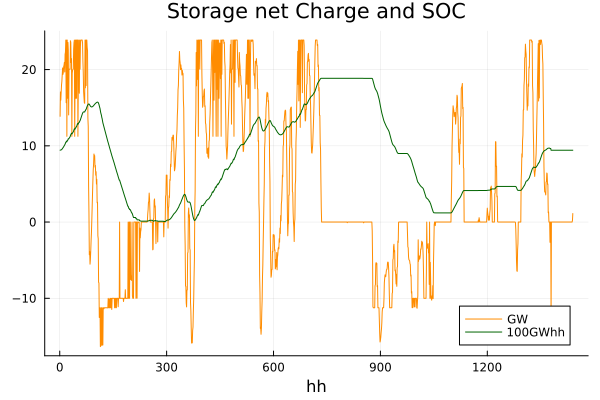

In [91]:
using Plots
tmp_charge = vec(sum(c2s5.CHARGE, dims=1))
tmp_discharge = vec(sum(c2s5.DISCHARGE, dims=1))
net = (tmp_charge - tmp_discharge) ./ 1000
tmp_soc = vec(sum(c2s5.SOC,dims=1)) ./ 100000
plot(net, label="GW", title="Storage net Charge and SOC (1 Month)", color="darkorange")
plot!(tmp_soc, label="100GWhh", xlabel="hh", color="darkgreen")

In [93]:
c2s5_90days = case2scheme5(vreinfo, generatorinfo, storageinfo, halfhourlydemand, halfhourlyvrecf; 
budget=20e9, voll=1e6, bigm=100e3, epsilon=0.05)

Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
336915 rows, 273934 cols, 1077358 nonzeros
289724 rows, 226743 cols, 1281666 nonzeros
289724 rows, 226743 cols, 1281666 nonzeros
Presolve : Reductions: rows 289724(-60207); columns 226743(-49767); elements 1281666(+188688)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 8640(1.69773e+09) 0s
       2493     1.0847914655e+04 Pr: 74452(4.63918e+11); Du: 0(5.01934e-07) 6s
       4853     1.8762312335e+04 Pr: 61733(2.21052e+12); Du: 0(1.14937e-06) 12s
       7135     2.5310712598e+04 Pr: 40410(2.21191e+11); Du: 0(1.09109e-06) 17s
       9170     3.2605606056e+04 Pr: 54121(1.59022e+12); Du: 0(1.73405e-06) 23s
      11286     4.1953291994e+04 Pr: 58702(5.19347e+12); Du: 0(1.93155e-06) 28s
      13246     4.7901947285e+04 Pr: 63444(8.58144e+11); Du: 0(1.89407e-06) 34s
      15247     5.3903018402e+0

(CAPG = [6544.647450280454, 26788.600000000002], CAPS = [0.0, 7830.68314003211, 0.0, 0.0, 2433.9673794121773, 0.0, 0.0, 0.0, -0.0, -0.0, 14356.772030275255, -0.0, -0.0, 0.0], SOCM = [-0.0, 1.389893444435088e6, -0.0, -0.0, 199293.24902626977, -0.0, -0.0, -0.0, -0.0, -0.0, 92124.30650041845, -0.0, -0.0, -0.0], GEN = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], R_GEN = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], SOC = [-0.0 -0.0 … -0.0 -0.0; 694946.722217544 700193.2799213656 … 689700.1645137224 694946.722217544; … ; -0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … -0.0 -0.0], CHARGE = [0.0 -0.0 … 0.0 0.0; 0.0 7830.68314003211 … 7830.68314003211 7830.68314003211; … ; -0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … -0.0 -0.0], DISCHARGE = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 -0.0], R_DISCHARGE = [0.0 0.0 … 0.0 0.0; 0.0 7424.330000000001 … 7351.400000000001 7338.17; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], NET_DISCHARGE = [0.0 0.0 … 0.0 0.0; 0.0 -7830.68314003211 … -7830.68314003211 -7

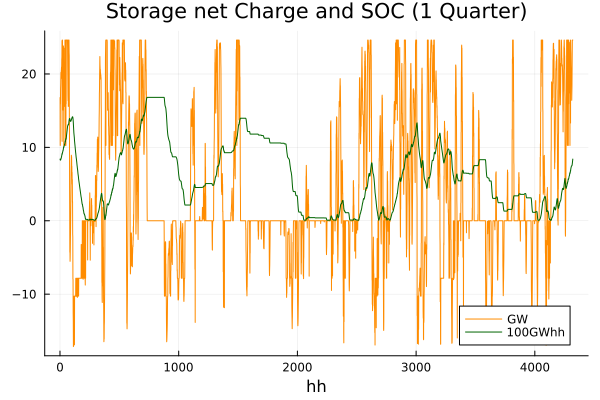

In [94]:
tmp_charge_90days = vec(sum(c2s5_90days.CHARGE, dims=1))
tmp_discharge_90days = vec(sum(c2s5_90days.DISCHARGE, dims=1))
net_90days = (tmp_charge_90days - tmp_discharge_90days) ./ 1000
tmp_soc_90days = vec(sum(c2s5_90days.SOC,dims=1)) ./ 100000
plot(net_90days, label="GW", title="Storage net Charge and SOC (1 Quarter)", color="darkorange")
plot!(tmp_soc_90days, label="100GWhh", xlabel="hh", color="darkgreen")

In [98]:
c2s5_1y = case2scheme5(vreinfo, generatorinfo, storageinfo, halfhourlydemand, halfhourlyvrecf; 
budget=20e9, voll=1e6, bigm=100e3, epsilon=0.05)

Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
1366515 rows, 1112758 cols, 4371382 nonzeros
1175085 rows, 921328 cols, 5200244 nonzeros
1175085 rows, 921328 cols, 5200244 nonzeros
Presolve : Reductions: rows 1175085(-244046); columns 921328(-199982); elements 5200244(+767666)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 35040(6.21353e+09) 5s
        737     1.0175054441e+03 Pr: 105495(1.05013e+11); Du: 0(1.74991e-07) 10s
       1222     1.7943841945e+03 Pr: 245720(8.18924e+11); Du: 0(4.00016e-07) 16s
       1685     2.4580262298e+03 Pr: 228581(1.6555e+12); Du: 0(4.24909e-07) 23s
       2163     3.9191039834e+03 Pr: 263793(1.47241e+13); Du: 0(5.98324e-07) 31s
       2642     5.4297853564e+03 Pr: 334183(1.24634e+12); Du: 0(9.19277e-07) 39s
       3079     6.9648453294e+03 Pr: 211416(1.26894e+12); Du: 0(8.26274e-07) 46s
       3583     8

(CAPG = [10129.337363767803, 21056.903013775154], CAPS = [-0.0, 8463.197318645496, -0.0, -0.0, 666.4296224570427, 0.0, -0.0, -0.0, 2199.399999999998, -0.0, 15439.402681354506, -0.0, -0.0, -0.0], SOCM = [-0.0, 1.2524980323613668e6, -0.0, -0.0, 52027.00492374948, -0.0, -0.0, -0.0, 58311.38333333325, -0.0, 137530.24787868804, -0.0, -0.0, -0.0], GEN = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], R_GEN = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], SOC = [-0.0 -0.0 … -0.0 -0.0; 626249.0161806834 631919.3583841759 … 626249.0161806834 626249.0161806834; … ; -0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … -0.0 -0.0], CHARGE = [0.0 0.0 … 0.0 0.0; 0.0 8463.197318645496 … 0.0 0.0; … ; 0.0 -0.0 … -0.0 -0.0; 0.0 -0.0 … -0.0 -0.0], DISCHARGE = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 -0.0 … -0.0 -0.0], R_DISCHARGE = [0.0 0.0 … 0.0 0.0; 0.0 6757.900377542958 … 7384.01 4793.09; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], NET_DISCHARGE = [0.0 0.0 … 0.0 0.0; 0.0 -8463.197318645496 … 0.0 0.0; … ; 0.0 0.

In [99]:
c2s5_1y

(CAPG = [10129.337363767803, 21056.903013775154], CAPS = [-0.0, 8463.197318645496, -0.0, -0.0, 666.4296224570427, 0.0, -0.0, -0.0, 2199.399999999998, -0.0, 15439.402681354506, -0.0, -0.0, -0.0], SOCM = [-0.0, 1.2524980323613668e6, -0.0, -0.0, 52027.00492374948, -0.0, -0.0, -0.0, 58311.38333333325, -0.0, 137530.24787868804, -0.0, -0.0, -0.0], GEN = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], R_GEN = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], SOC = [-0.0 -0.0 … -0.0 -0.0; 626249.0161806834 631919.3583841759 … 626249.0161806834 626249.0161806834; … ; -0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … -0.0 -0.0], CHARGE = [0.0 0.0 … 0.0 0.0; 0.0 8463.197318645496 … 0.0 0.0; … ; 0.0 -0.0 … -0.0 -0.0; 0.0 -0.0 … -0.0 -0.0], DISCHARGE = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 -0.0 … -0.0 -0.0], R_DISCHARGE = [0.0 0.0 … 0.0 0.0; 0.0 6757.900377542958 … 7384.01 4793.09; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], NET_DISCHARGE = [0.0 0.0 … 0.0 0.0; 0.0 -8463.197318645496 … 0.0 0.0; … ; 0.0 0.

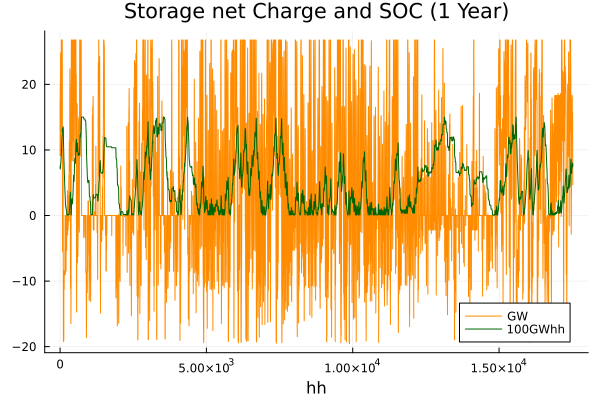

In [100]:
tmp_charge_1y = vec(sum(c2s5_1y.CHARGE, dims=1))
tmp_discharge_1y = vec(sum(c2s5_1y.DISCHARGE, dims=1))
net_1y = (tmp_charge_1y - tmp_discharge_1y) ./ 1000
tmp_soc_1y = vec(sum(c2s5_1y.SOC,dims=1)) ./ 100000
plot(net_1y, label="GW", title="Storage net Charge and SOC (1 Year)", color="darkorange")
plot!(tmp_soc_1y, label="100GWhh", xlabel="hh", color="darkgreen")

In [101]:
tmp_charge_1y

17520-element Vector{Float64}:
 17712.800000000003
 26768.429622457043
 26768.429622457043
 26768.429622457043
 26768.429622457043
 26768.429622457043
 26768.429622457043
 26768.429622457043
 26768.429622457043
 26768.429622457043
     ⋮
 18305.232303811546
 18305.232303811546
 18305.232303811546
 18305.232303811546
 18305.232303811546
 18305.232303811546
 18305.232303811546
 18305.232303811546
 18305.232303811546

In [102]:
c2s5_1y

(CAPG = [10129.337363767803, 21056.903013775154], CAPS = [-0.0, 8463.197318645496, -0.0, -0.0, 666.4296224570427, 0.0, -0.0, -0.0, 2199.399999999998, -0.0, 15439.402681354506, -0.0, -0.0, -0.0], SOCM = [-0.0, 1.2524980323613668e6, -0.0, -0.0, 52027.00492374948, -0.0, -0.0, -0.0, 58311.38333333325, -0.0, 137530.24787868804, -0.0, -0.0, -0.0], GEN = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], R_GEN = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], SOC = [-0.0 -0.0 … -0.0 -0.0; 626249.0161806834 631919.3583841759 … 626249.0161806834 626249.0161806834; … ; -0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … -0.0 -0.0], CHARGE = [0.0 0.0 … 0.0 0.0; 0.0 8463.197318645496 … 0.0 0.0; … ; 0.0 -0.0 … -0.0 -0.0; 0.0 -0.0 … -0.0 -0.0], DISCHARGE = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 -0.0 … -0.0 -0.0], R_DISCHARGE = [0.0 0.0 … 0.0 0.0; 0.0 6757.900377542958 … 7384.01 4793.09; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], NET_DISCHARGE = [0.0 0.0 … 0.0 0.0; 0.0 -8463.197318645496 … 0.0 0.0; … ; 0.0 0.

In [103]:
write_to_csv(variable_name, data) = CSV.write(joinpath("results", "$variable_name.csv"), DataFrame(variable_name => data))

write_to_csv (generic function with 1 method)

In [105]:
results = c2s5_1y

(CAPG = [10129.337363767803, 21056.903013775154], CAPS = [-0.0, 8463.197318645496, -0.0, -0.0, 666.4296224570427, 0.0, -0.0, -0.0, 2199.399999999998, -0.0, 15439.402681354506, -0.0, -0.0, -0.0], SOCM = [-0.0, 1.2524980323613668e6, -0.0, -0.0, 52027.00492374948, -0.0, -0.0, -0.0, 58311.38333333325, -0.0, 137530.24787868804, -0.0, -0.0, -0.0], GEN = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], R_GEN = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], SOC = [-0.0 -0.0 … -0.0 -0.0; 626249.0161806834 631919.3583841759 … 626249.0161806834 626249.0161806834; … ; -0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … -0.0 -0.0], CHARGE = [0.0 0.0 … 0.0 0.0; 0.0 8463.197318645496 … 0.0 0.0; … ; 0.0 -0.0 … -0.0 -0.0; 0.0 -0.0 … -0.0 -0.0], DISCHARGE = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 -0.0 … -0.0 -0.0], R_DISCHARGE = [0.0 0.0 … 0.0 0.0; 0.0 6757.900377542958 … 7384.01 4793.09; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], NET_DISCHARGE = [0.0 0.0 … 0.0 0.0; 0.0 -8463.197318645496 … 0.0 0.0; … ; 0.0 0.

In [118]:
for key in keys(results)
    CSV.write(joinpath("results", "$variable_name.csv"), DataFrame(variable_name => data))
end

CAPG
CAPS
SOCM
GEN


ArgumentError: ArgumentError: adding AbstractArray other than AbstractVector as a column of a data frame is not allowed

In [111]:
results[key]

UndefVarError: UndefVarError: `key` not defined

In [113]:
tmp = keys(results)

(:CAPG, :CAPS, :SOCM, :GEN, :R_GEN, :SOC, :CHARGE, :DISCHARGE, :R_DISCHARGE, :NET_DISCHARGE, :CURTAIL, :NSE, :GenInvCost, :StorPowInvCost, :StorEnInvCost, :TIC, :EnergyProvisionCost, :ReserveProvisionCost, :UnservedEnergyCost, :CurtailedVreCost, :OV)

In [116]:
results[tmp[1]]

2-element Vector{Float64}:
 10129.337363767803
 21056.903013775154

In [120]:
c2s5.R_DISCHARGE

14×1440 Matrix{Float64}:
    0.0      0.0      0.0      0.0    …     0.0      0.0      0.0      0.0
 6165.78  1602.64  1451.03   352.017        0.0   7601.72     0.0   7512.89
   -0.0      0.0      0.0     -0.0         -0.0      0.0     -0.0      0.0
   -0.0      0.0      0.0      0.0          0.0      0.0      0.0      0.0
 1239.2      0.0   1239.2   1239.2          0.0      0.0   1239.2      0.0
   -0.0      0.0      0.0      0.0    …     0.0      0.0      0.0      0.0
    0.0      0.0      0.0      0.0          0.0      0.0      0.0      0.0
   -0.0     -0.0     -0.0     -0.0         -0.0      0.0     -0.0      0.0
    0.0      0.0      0.0      0.0          0.0      0.0      0.0      0.0
    0.0      0.0     -0.0     -0.0         -0.0      0.0     -0.0      0.0
    0.0   5821.69  4743.49  5810.49   …  7656.77     0.0   6301.14     0.0
    0.0      0.0      0.0      0.0          0.0      0.0      0.0      0.0
    0.0      0.0      0.0      0.0          0.0      0.0      0.0      0.0

In [123]:
c2s5.SOC

14×1440 Matrix{Float64}:
    -0.0           -0.0           -0.0        …     -0.0           -0.0
     8.64517e5      8.71222e5      8.77926e5         8.63768e5      8.64517e5
    -0.0           -0.0           -0.0              -0.0           -0.0
    -0.0           -0.0           -0.0              -0.0           -0.0
 50455.4        51025.5        51595.5           50455.4        50455.4
    -0.0           -0.0           -0.0        …     -0.0           -0.0
    -0.0           -0.0           -0.0              -0.0           -0.0
    -0.0           -0.0           -0.0              -0.0           -0.0
    -0.0           -0.0           -0.0              -0.0           -0.0
    -0.0           -0.0           -0.0              -0.0           -0.0
 27791.6        22362.4        14972.7        …  27791.6        27791.6
    -0.0           -0.0           -0.0              -0.0           -0.0
    -0.0           -0.0           -0.0              -0.0           -0.0
    -0.0           -0.0          

In [137]:
minimum(c2s5.SOC .- (c2s5.R_DISCHARGE ./ 1))

-0.0